## Modelo de classificação Cães e Gatos usando Redes Neurais Convolucionais

Importando as bibliotecas necessárias:

In [1]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
from torch import optim
from torch.utils.data import DataLoader,Dataset

device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from glob import glob

# Importando dataset

Usaremos a API do kaggle para importar nosso dataset para o Google Colab, para isso você precisa um token de API do kaggle. Crie uma conta no kaggle e vá em **"Your Profile"**, **"Account"** e clique em **"Create new token"**, isso irá fazer o download do arquivo **kaggle.json** no seu computador. Caso você já tenha esse arquivo, ignore essa etapa.

Agora iremos importar nosso arquivo **kaggle.json** neste notebook do google colab.

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"viniciusrabello","key":"795059f82b2c06847fc017dc3ca2e5de"}'}

Essa caixa de código cria uma pasta oculta neste notebook, e copia o **kaggle.json** para ela.

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


Aqui estamos importando o dataset diretamente para o notebook, sem precisar fazer o download para o computador. Veja que o arquivo vem em formato **.zip** e nós fazemos o **unzip** diretamente pelo colab.

A url do dataset que será utilizado é https://www.kaggle.com/datasets/tongpython/cat-and-dog, passamos o que está após **datasets/** como parâmetro para baixar na caixa de código abaixo.

In [4]:
!kaggle datasets download -d tongpython/cat-and-dog
!unzip cat-and-dog.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jpg 

# Conjuntos de treino e teste

Definimos uma classe que irá gerar como objetos, o training set e o test set do nosso modelo

In [ ]:
train_path='training_set/training_set'
test_path='test_set/test_set'

In [ ]:
class cats_dogs(Dataset):
    def __init__(self,folder):
        cats=glob(folder+'/cats/*.jpg')
        dogs=glob(folder+'/dogs/*.jpg')
        self.filepaths=cats+dogs
        np.random.shuffle(self.filepaths)
        self.targets=[int(path.split('/')[-1].startswith('dog')) for path in self.filepaths]
        
    def __len__(self):
        return len(self.filepaths)
    
    def __getitem__(self,i):
        img=self.filepaths[i]
        target=self.targets[i]
        img=cv2.imread(img)
        img=cv2.resize(img,(128,128))
        img=torch.tensor(img/255).permute(2,0,1)
        target=torch.tensor([target])
        return img.to(device).float(),target.to(device).float()

Uma imagem aleatória do training set

tensor([0.], device='cuda:0')


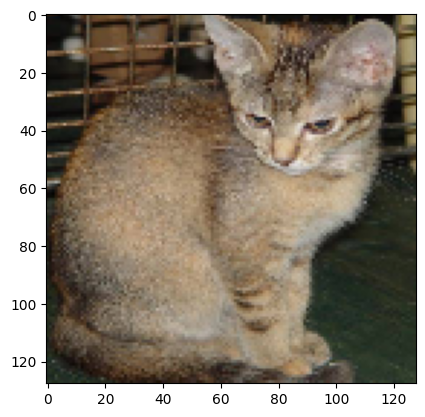

In [ ]:
data=cats_dogs(train_path)
img,label=data[0]
img=img.permute(1,2,0).cpu()
img=np.array(img)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

plt.imshow(img)
print(label)

Definindo o modelo

In [ ]:
def conv_layer(n_inputs,n_outputs,kernel_size,stride=1):
    return nn.Sequential(
        nn.Conv2d(n_inputs, n_outputs, kernel_size, stride),
        nn.ReLU(),
        nn.BatchNorm2d(n_outputs),
        nn.MaxPool2d(2))

In [ ]:
def get_model():
    model = nn.Sequential(
        conv_layer(3, 64, 3),
        conv_layer(64, 128, 3),
        conv_layer(128, 128, 3),
        conv_layer(128, 64, 3),
        conv_layer(64, 32, 1),
        nn.Flatten(),
        nn.Linear(288, 1),
        nn.Sigmoid(),).to(device)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model, loss_fn, optimizer

In [ ]:
from torchsummary import summary

model,loss_fn,optimizer=get_model()
summary(model,(3,128,128));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 126, 126]           1,792
              ReLU-2         [-1, 64, 126, 126]               0
       BatchNorm2d-3         [-1, 64, 126, 126]             128
         MaxPool2d-4           [-1, 64, 63, 63]               0
            Conv2d-5          [-1, 128, 61, 61]          73,856
              ReLU-6          [-1, 128, 61, 61]               0
       BatchNorm2d-7          [-1, 128, 61, 61]             256
         MaxPool2d-8          [-1, 128, 30, 30]               0
            Conv2d-9          [-1, 128, 28, 28]         147,584
             ReLU-10          [-1, 128, 28, 28]               0
      BatchNorm2d-11          [-1, 128, 28, 28]             256
        MaxPool2d-12          [-1, 128, 14, 14]               0
           Conv2d-13           [-1, 64, 12, 12]          73,792
             ReLU-14           [-1, 64,

# O Modelo

Definindo funções para o treinamento do modelo

In [ ]:
def get_data():
    train_set=cats_dogs(train_path)
    train_dl=DataLoader(train_set,batch_size=32,shuffle=True,drop_last=True)
    valid_set=cats_dogs(test_path)
    valid_dl=DataLoader(valid_set,batch_size=32,shuffle=True,drop_last=True)
    return train_dl, valid_dl

In [ ]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [ ]:
@torch.no_grad()
def accuracy(x, y, model):
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [ ]:
@torch.no_grad()
def valid_loss(x, y, model):
    prediction = model(x)
    valid_loss = loss_fn(prediction, y)
    return valid_loss.item()

Treinando o modelo

In [ ]:
train_dl,valid_dl=get_data()
model,loss_fn,optimizer=get_model()

In [ ]:
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

for epoch in range(5):
    train_epoch_losses, train_epoch_accuracies = [], []
    valid_epoch_accuracies = []
    
    for batch in iter(train_dl):
        x,y=batch
        batch_loss = train_batch(x, y, model, optimizer,loss_fn)
        train_epoch_losses.append(batch_loss)
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for batch in iter(valid_dl):
        x, y = batch
        valid_is_correct = accuracy(x, y, model)
        valid_epoch_accuracies.extend(valid_is_correct)
    valid_epoch_accuracy = np.mean(valid_epoch_accuracies)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    valid_accuracies.append(valid_epoch_accuracy)

# Resultados

Agora, com o modelo treinado, plotamos a acurácia do treino e da validação ao longo das épocas

<ipython-input-56-0b815517cdfb>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


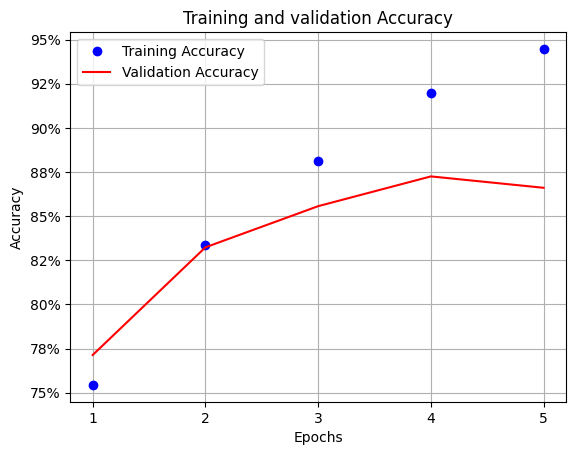

Model Accuracy = 0.8660714285714286


In [ ]:
epochs = np.arange(5)+1

import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline


plt.plot(epochs, train_accuracies, 'bo',label='Training Accuracy')
plt.plot(epochs, valid_accuracies, 'r',label='Validation Accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

print('Model Accuracy = {}'.format(valid_accuracies[-1]))

Podemos salvar nosso modelo com **torch.save(modelo, 'nome do modelo')**, isso irá armazenar o modelo treinado aqui no colab e podemos fazer o download para o nosso computador. (em arquivos, na aba da direita)

In [ ]:
#torch.save(model,'catdogcnn_model')

O benefício de salvar o modelo no computador é que podemos fazer o upload dele já treinado, ou seja, não precisamos treinar ele novamente. Fazemos o upload igual fizemos com o **kaggle.json** no início do notebook

In [ ]:
from google.colab import files
files.upload()

E agora **torch.load('nome do modelo')**

In [ ]:
model=torch.load('catdogcnn_model')

Aqui testando o modelo em uma imagem aleatória do test set (o output do modelo é um valor de 0 a 1, se esse valor é maior que 0.5 a previsão é de um cachorro, caso contrário um gato)

Segundo o modelo a imagem mostra um Cachorro


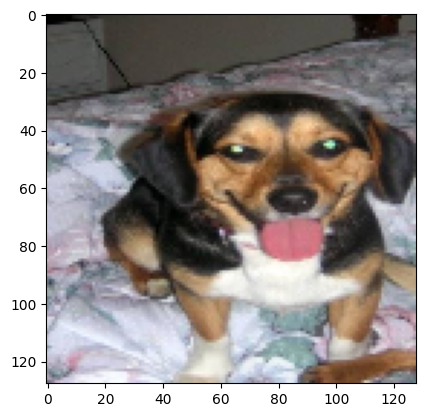

In [ ]:
data=cats_dogs(test_path)
img,_=data[0]
prediction=model(img.unsqueeze(0))

if prediction > .5:
  label='Cachorro'
else:
  label='Gato'

img=img.permute(1,2,0).cpu()
img=np.array(img)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

plt.imshow(img)
print('Segundo o modelo a imagem mostra um '+label)

# Visualizando os outputs de cada camada

Essa é uma imagem do dataset como ela é recebida pelo modelo, sem nenhum tipo de pré-processamento feito em cima

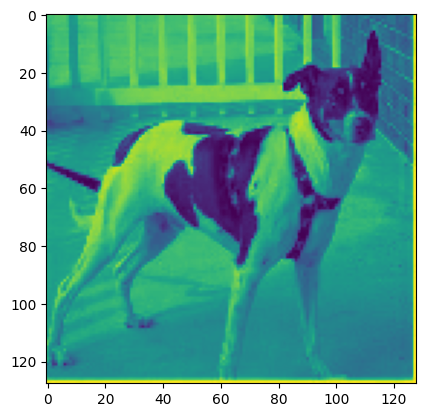

In [ ]:
i=np.random.choice(len(data))
img,label=data[i]
plt.imshow(img[0].cpu())
plt.show()

# Acessando a primeira camada do modelo

In [ ]:
first_layer = nn.Sequential(*list(model.children())[:1]) # Podemos listar as camadas do modelo com a função model.children, transformamos em list e pegamos apenas até a primeira camada
intermediate_output = first_layer(img[None])[0].detach()

In [ ]:
first_layer,intermediate_output.shape

(Sequential(
   (0): Sequential(
     (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
     (1): ReLU()
     (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
 ),
 torch.Size([64, 63, 63]))

A primeira camada recebe 3 inputs (os 3 canais da imagem) e retorna 64 imagens como output

Outputs da primeira camada:

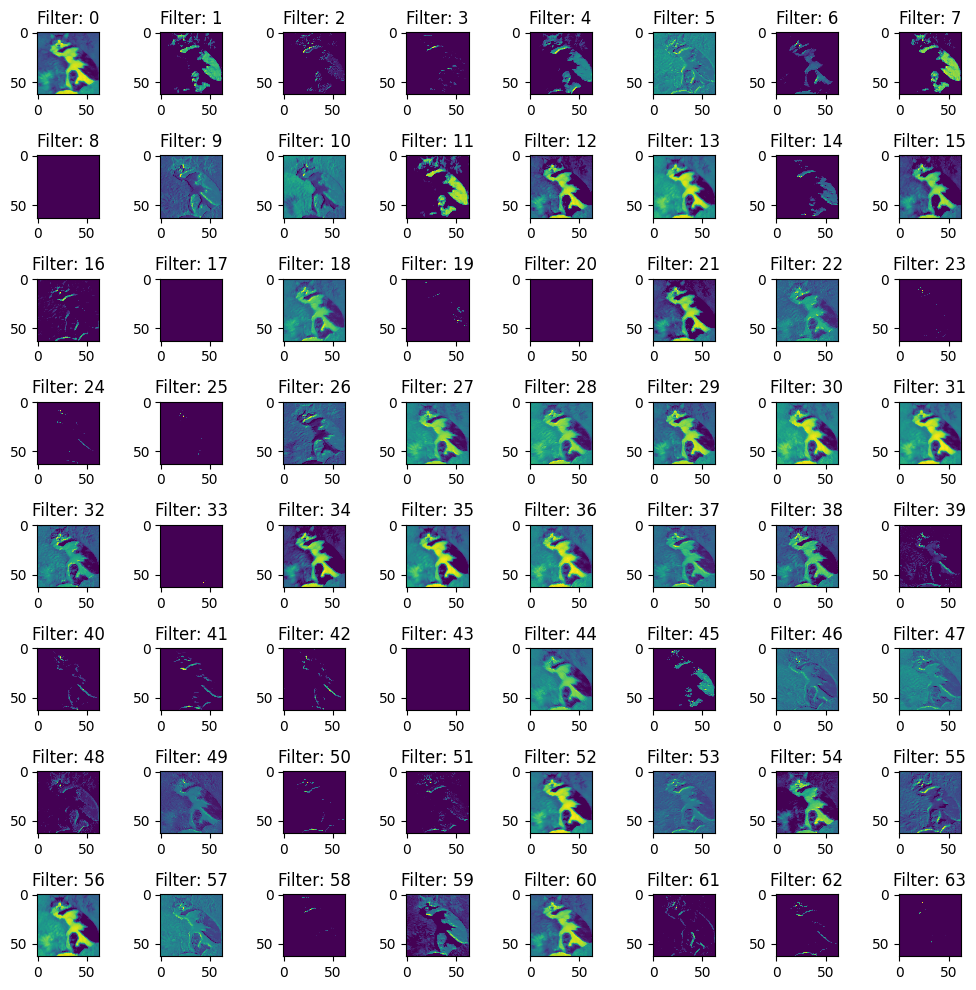

In [ ]:
fig, ax = plt.subplots(8, 8, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
  axis.set_title('Filter: '+str(ix))
  axis.imshow(intermediate_output[ix].cpu())
plt.tight_layout()
plt.show()

In [ ]:
x,y=next(iter(train_dl))
ix=[i for i in range(len(y)) if y[i]==1]
x_dog=x[ix] # uma lista com apenas imagens de cachorro

In [1]:
first_layer = nn.Sequential(*list(model.children())[:1]) # repetindo a mesma etapa
first_layer_output = first_layer(x_dog).detach() # passando diversas imagens de cachorro pela primeira camada

NameError: ignored

In [ ]:
first_layer_output.shape

torch.Size([18, 64, 63, 63])

Diferentes imagens passando pelo mesmo node da camada

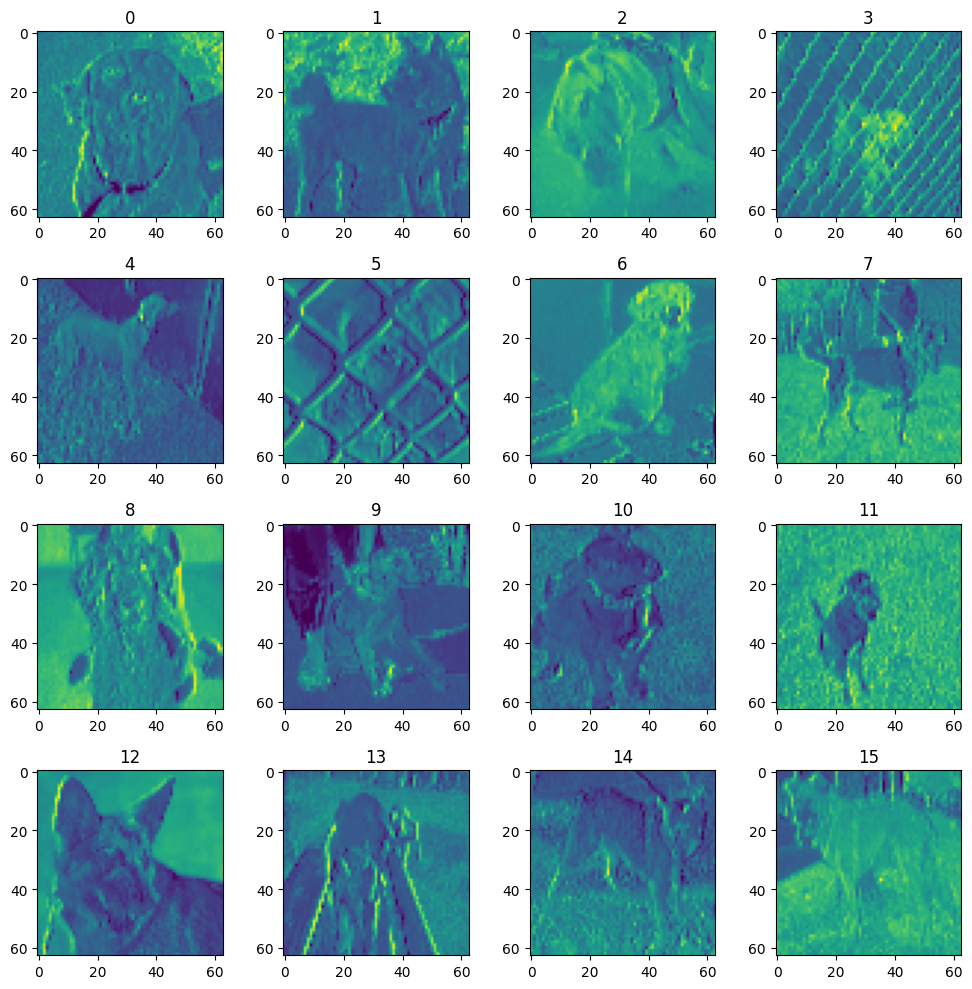

In [ ]:
node=10
fig, ax = plt.subplots(4, 4, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
  axis.imshow(first_layer_output[ix,node,:,:].cpu())
  axis.set_title(str(ix))
  plt.tight_layout()
plt.show()

# Acessando a segunda camada do modelo

Igual fizemos com a primeira camada

In [ ]:
second_layer = nn.Sequential(*list(model.children())[:2])
second_layer_output=second_layer(img[None])[0].detach()

A mesma imagem como vista por 16 nodes da segunda camada (são 128 no total, escolhi 16 para obtermos imagens maiores)

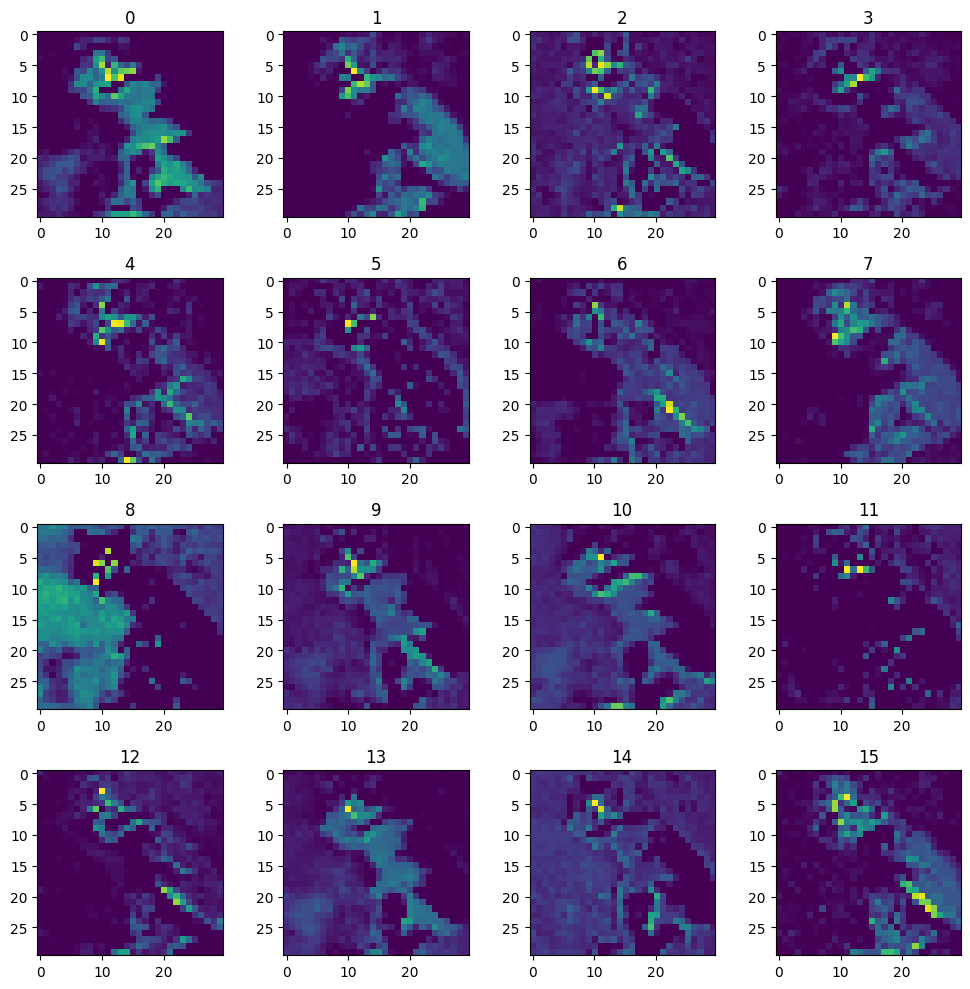

In [ ]:
fig, ax = plt.subplots(4,4, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
  axis.imshow(second_layer_output[ix].cpu())
  axis.set_title(str(ix))
plt.tight_layout()
plt.show()

Diversas imagens pelo mesmo node da segunda camada

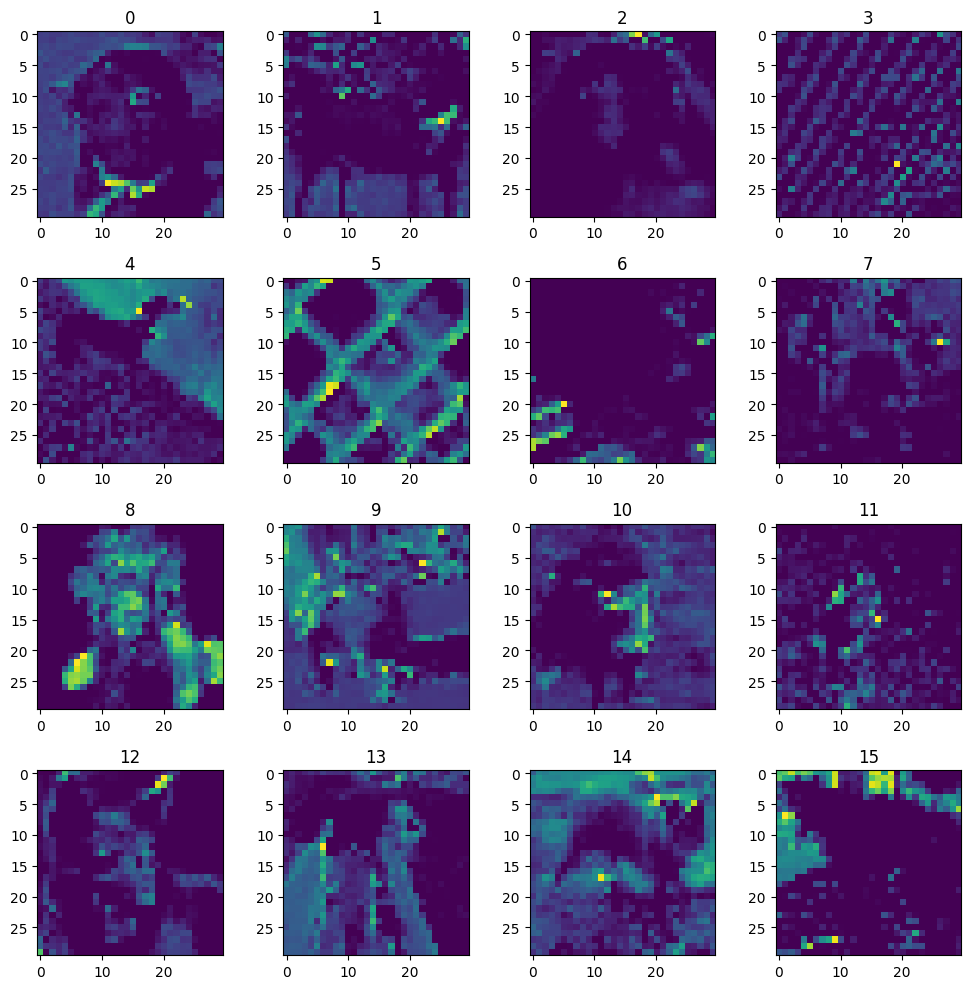

In [ ]:
second_layer = nn.Sequential(*list(model.children())[:2])
second_layer_output = second_layer(x_dog).detach()

node=0

fig, ax = plt.subplots(4, 4, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
  axis.imshow(second_layer_output[ix,node,:,:].cpu())
  axis.set_title(str(ix))
plt.tight_layout()
plt.show()

In [ ]:
second_layer

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)

# Visualizando a última camada

In [ ]:
custom_dl=DataLoader(data,batch_size=50,shuffle=True,drop_last=True)

In [ ]:
x,y=next(iter(custom_dl))
ix=[i for i in range(len(y)) if y[i]==1]
x_dog=x[ix]

In [ ]:
flatten_layer = nn.Sequential(*list(model.children())[:6])
flatten_layer_output = flatten_layer(x_dog).detach()
flatten_layer_output.shape

torch.Size([25, 288])

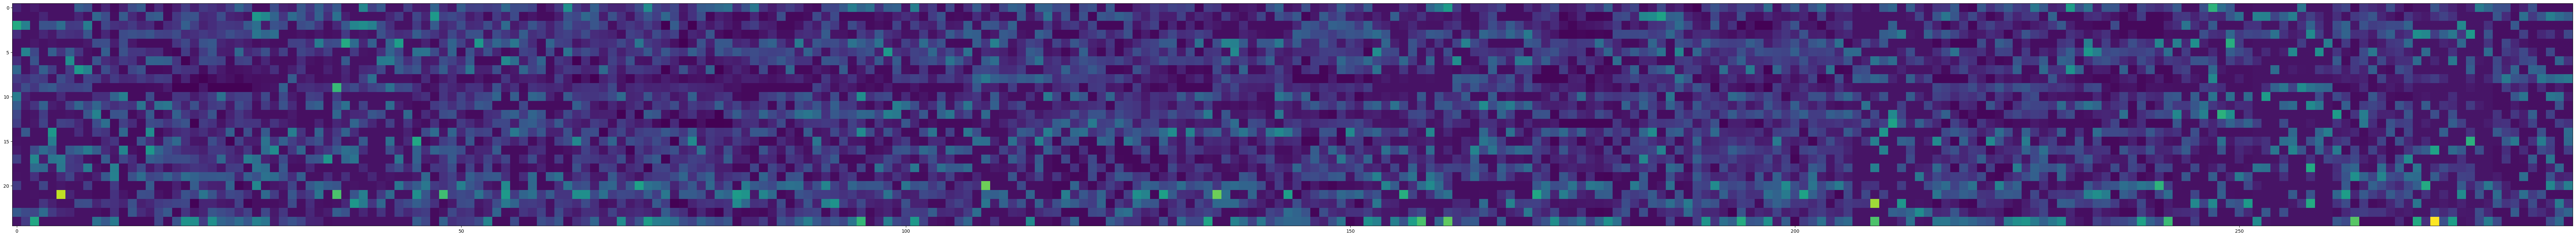

In [ ]:
plt.figure(figsize=(100,10))
plt.imshow(flatten_layer_output.cpu())